In [47]:
import torch
import torch.nn as nn
# from generate_data import *
import matplotlib.pyplot as plt
import numpy as np
import math 
from load_matlab_timedata import get_data_from
import sklearn.preprocessing 
from tqdm import tqdm_notebook as tqdm
import random
import yaml
import h5py
from torch.utils.data import Dataset, DataLoader, SequentialSampler, BatchSampler

In [48]:
! ls DC_motor_simulation

dc_engine_random_sig_const_periods.slx		 diff_eq_system.slx
dc_engine_random_sig_random_period.slx		 diff_eq_system.slx.original
dc_engine_random_sig_random_period.slx.autosave  res.mat
dc_engine_random_sig_random_period.slxc		 resources
DC_motor_simulation.prj				 slprj


In [49]:
plt.rcParams['figure.figsize'] = 20, 7.

In [50]:
data = get_data_from('DC_motor_simulation/res.mat')

<KeysViewHDF5 ['ans']>


In [51]:
CONFIG_FILENAME = "model_params.yaml"

In [52]:
# with open(CONFIG_FILENAME, 'r') as f:
#         config = yaml.load(f)

## KD: choosing simple value to avoid systematic error, as we have peacewise equal periods in data

In [53]:
leave_nth = 13

In [54]:
time, x, y = data[::leave_nth, 0], data[::leave_nth, 1], data[::leave_nth, 2]

In [55]:
# assert(x.shape == y.shape == time.shape)

In [56]:
num_datapoints = x.shape[0]
num_datapoints

76924

## To handle problems with equal splitting batches

In [57]:
num_datapoints -= num_datapoints % leave_nth
num_datapoints

76921

In [58]:
def get_func_timeseries(func, diapasone = (0, math.pi * 10, math.pi / 100)):
    T = [ t for t in np.arange(diapasone[0], diapasone[1], diapasone[2])]
    T = T[:num_datapoints]
    func_t = [func(t) for t in T]
    plt.plot(func_t)
    x = np.array(T)
    y = np.array(func_t)
    return (x,y)

In [59]:
try_sin = False
if try_sin:
    x, y = get_func_timeseries(func = math.sin)

In [60]:
x_normalized, x_norms = sklearn.preprocessing.normalize(x.reshape(-1,1),
                                                  axis = 0,
                                                  norm = 'max',
                                                  return_norm = True)
y_normalized, y_norms = sklearn.preprocessing.normalize(y.reshape(-1,1),
                                                  axis = 0,
                                                  norm = 'max', 
                                                  return_norm = True)

In [61]:
x = x_normalized
y = y_normalized

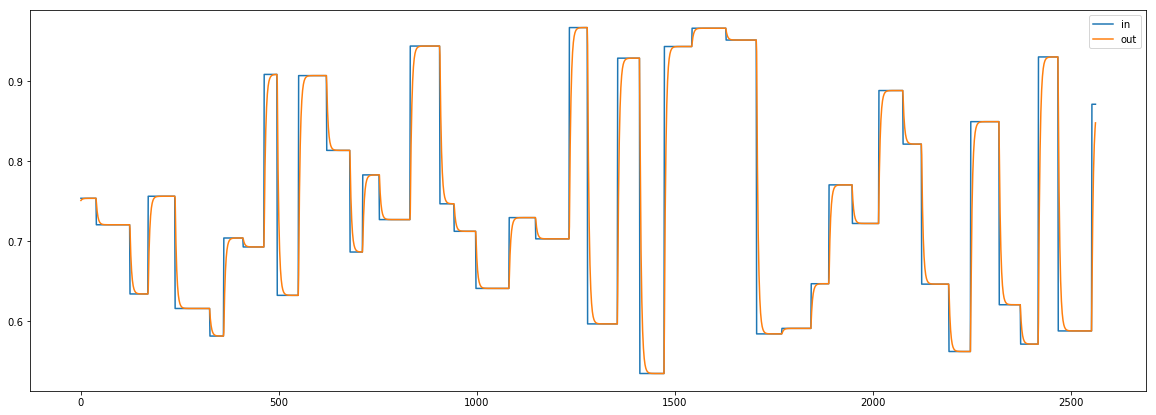

In [62]:
plt.plot(x[num_datapoints//6:num_datapoints//5], label = "in")
plt.plot(y[num_datapoints//6:num_datapoints//5], label = "out")
plt.legend()

Example of generating SIN wave of same len to werify model validity

In [63]:
#####################
# Set parameters
#####################

# Data params
noise_var = 0
num_datapoints = num_datapoints
test_size = 0.3
num_train = int((1-test_size) * num_datapoints)
num_test = num_datapoints - num_train
batch_size = 512
# Network params
input_size = 128
# If `per_element` is True, then LSTM reads in one timestep at a time.
per_element = True
if per_element:
    lstm_input_size = 1
else:
    lstm_input_size = input_size
# size of hidden layers
h1 = 16
output_dim = 1
num_layers = 2
learning_rate = 1e-3
num_epochs = 50000
dtype = torch.float


In [64]:
def get_batch(X, y, batch_size):
    batch_start = random.randint(0, X.shape[1] - batch_size);
    
    x_batch = X.narrow(1,batch_start,batch_size)
    
    y_batch = y.narrow(0, batch_start,batch_size)
    return (x_batch, y_batch)

In [65]:
x_batches = []
for i in range(1,input_size+1):
    x_batches.append(x[i:-(input_size+1-i)])
x = np.array(x_batches)
y = y[input_size:] 

In [66]:
# len(train_dl)

In [67]:
# x_batch, y_batch = get_batch(X_train, y_train, 200)

In [68]:
x_batch.shape

torch.Size([128, 512, 1])

In [69]:
# x.shape

In [70]:
# plt.plot(x[input_size-3][:100], label = 'x_n_mimus_2')
# plt.plot(x[input_size-2][:100], label = 'x_n_minus_1')
# plt.plot(x[input_size-1][:100], label = 'x_n')
# plt.plot(y[:100], label='y_n')
# plt.legend()

In [71]:
# x.shape

In [72]:
generate_data = False
#####################
# Generate data
#####################
if generate_data:
    from examples.generate_data import *
    data = ARData(num_datapoints,
                  num_prev=input_size,
                  test_size=test_size, 
                  noise_var=noise_var,
                  coeffs=fixed_ar_coefficients[input_size])

    # make training and test sets in torch
    X_train = torch.from_numpy(data.X_train).type(torch.Tensor)
    X_test = torch.from_numpy(data.X_test).type(torch.Tensor)
    y_train = torch.from_numpy(data.y_train).type(torch.Tensor).view(-1)
    y_test = torch.from_numpy(data.y_test).type(torch.Tensor).view(-1)

    X_train = X_train.view([input_size, -1, 1])
    X_test = X_test.view([input_size, -1, 1])
    plt.plot(data.X_train[:20, 12], label = '12')
    plt.plot(data.X_train[:20, 16], label = '16')
    plt.plot(data.X_train[:20, 19], label = '19')
    plt.plot(data.y_train[:20], label = 'out')

    plt.legend()

In [73]:
# x.shape

In [74]:
X_train = torch.from_numpy(x[:, :num_train]).type(torch.Tensor)

In [75]:
# b = x[:, :num_train]
# b.shape

In [76]:
# X_train.shape

In [77]:
X_train = torch.from_numpy(x[:, :num_train]).type(torch.Tensor)
# X_test = torch.from_numpy(x[:, num_train:]).type(torch.Tensor)
X_train = X_train.view([input_size, -1, 1])
# X_test = X_test.view([input_size, -1, 1])
y_train = torch.from_numpy(y[:num_train, :]).type(torch.Tensor).view(-1)
# y_test = torch.from_numpy(y[num_train:, :]).type(torch.Tensor).view(-1)

In [78]:
tst = np.zeros_like(x[:, :num_train])
tst[:,:x.shape[1] - num_train].shape
tst[:,:x.shape[1] - num_train] += x[:, num_train:]
X_test = torch.from_numpy(tst).type(torch.Tensor)
X_test = X_test.view([input_size, -1, 1])
y_tst = np.zeros_like(y[:num_train, :])
y_tst[:y.shape[0] - num_train, :] = y[num_train:, :]
y_test = torch.from_numpy(y_tst).type(torch.Tensor).view(-1)

In [79]:
X_train.shape

torch.Size([128, 53844, 1])

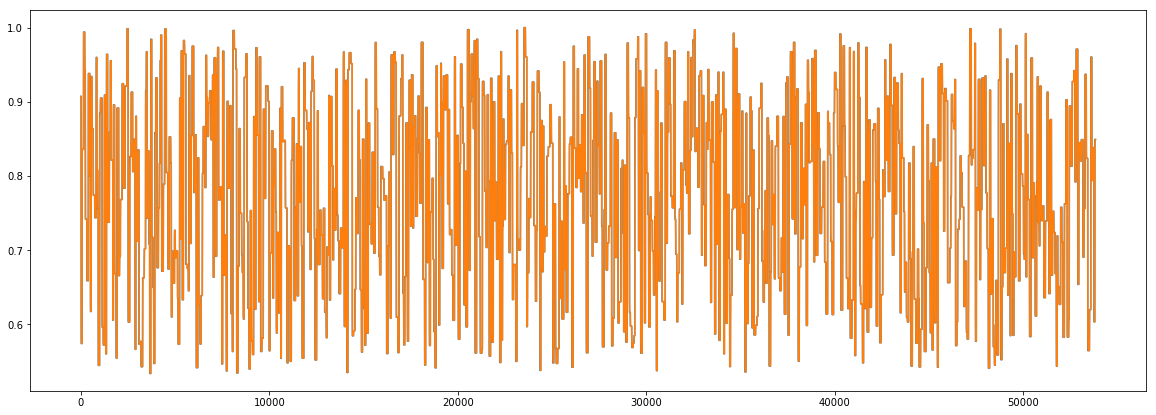

In [80]:
plt.plot(X_train.detach().numpy()[input_size-2])
plt.plot(y_train.detach().numpy())

In [81]:
from torch.utils.data import Dataset, DataLoader, SequentialSampler
import sklearn.preprocessing 
class TimeSeriesDataset(Dataset):
    """Loads dataset from matlab file and provides batching interface"""

    def __init__(self, mat_file, retrospective_steps, partition, need_normalize=True, leave_nth = 1, transform=None):
        """
        Args:
            mat_file (string): Path to the mat file with annotations.
            root_dir (string): Directory with all the images.
            
            transform (callable, optional): Optional transform to be applied
            
                on a sample.
        """
        outfile = h5py.File(mat_file, 'r')
        #print(outfile.keys())
        self.data  = outfile['ans']
        time, x, y = self.data[::leave_nth, 0], self.data[::leave_nth, 1], self.data[::leave_nth, 2]
        if need_normalize:
            x_normalized, self.x_norms = sklearn.preprocessing.normalize(x.reshape(-1,1),
                                                      axis = 0,
                                                      norm = 'max',
                                                      return_norm = True)
            y_normalized, self.y_norms = sklearn.preprocessing.normalize(y.reshape(-1,1),
                                                      axis = 0,
                                                      norm = 'max', 
                                                      return_norm = True)
            x = x_normalized
            y = y_normalized
            
        print(x.shape)
        x = x[ int(partition[0] * x.shape[0]) : int(partition[1] * x.shape[0])]
        print(x.shape)
        y = y[ int(partition[0] * y.shape[0]) : int(partition[1] * y.shape[0])]
        x_sliding = []  # determines number of steps for retrospective view
        for i in range(1,retrospective_steps+1):
            x_sliding.append(x[i:-(retrospective_steps+1-i)])
        y = y[retrospective_steps:]
        #print(y.shape)
        self.x = torch.from_numpy(np.array(x_sliding)).type(torch.Tensor)
        print("before")
        print(self.x.shape)
        
        self.x = self.x.view([input_size, -1, 1])
        print("after")
        print(self.x.shape)
        self.y = torch.from_numpy(y).type(torch.Tensor).view(-1)
        #print(self.y.shape)
        self.transform = transform

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, idx):
        return self.x[:, idx], self.y[idx], idx

In [82]:
test_size

0.3

In [83]:
train_ts_ds = TimeSeriesDataset(mat_file='DC_motor_simulation/res.mat',
                                retrospective_steps=input_size,
                                partition=(0, 1 - test_size),
                                need_normalize=True, leave_nth=13)
test_ts_ds = TimeSeriesDataset(mat_file='DC_motor_simulation/res.mat',
                                retrospective_steps=input_size,
                                partition=(1 - test_size, 1),
                                need_normalize=True, leave_nth=13)

(76924, 1)
(53846, 1)
before
torch.Size([128, 53717, 1])
after
torch.Size([128, 53717, 1])
(76924, 1)
(23078, 1)
before
torch.Size([128, 22949, 1])
after
torch.Size([128, 22949, 1])


In [84]:
print(len(test_ts_ds))
len(train_ts_ds)

22950


53718

In [85]:
print(len(test_ts_ds))
len(train_ts_ds)

22950


53718

In [86]:
train_dl = DataLoader(dataset = train_ts_ds,
                 batch_sampler = BatchSampler(sampler = SequentialSampler(train_ts_ds), 
                              batch_size = batch_size, drop_last = True))
test_dl = DataLoader(dataset = test_ts_ds,
                 batch_sampler = BatchSampler(sampler = SequentialSampler(test_ts_ds), 
                              batch_size = batch_size, drop_last = True))


In [87]:
print(len(train_dl))
print(len(test_dl))

104
44


In [88]:
print(len(train_dl))
print(len(test_dl))

104
44


torch.Size([512, 128, 1])
128
torch.Size([512])


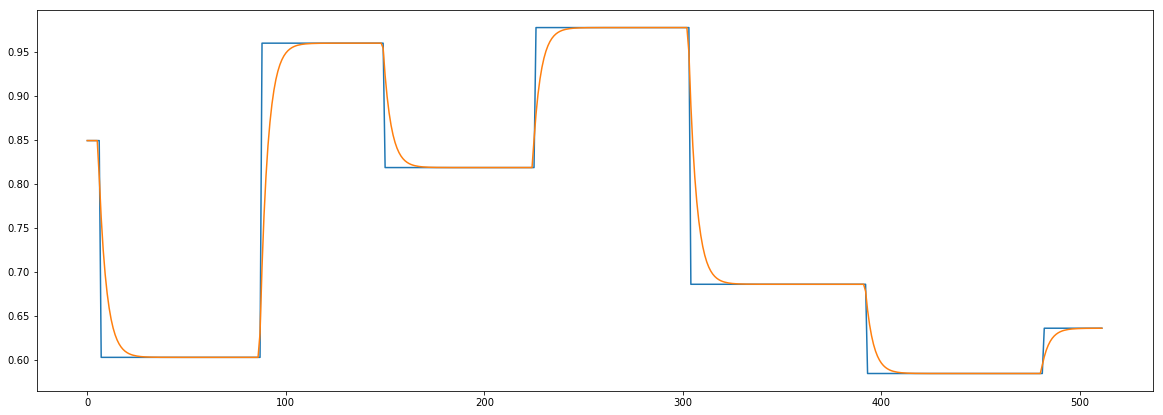

In [89]:
for i in test_dl:
    x, y, ind = i
    print(x.shape)
    x = x.transpose(0,1)
    plt.plot(x.detach().numpy()[-2])
    plt.plot(y.detach().numpy())
    print(len(x))
    print(y.shape)
    break

In [90]:

#####################
# Build model
#####################

# Here we define our model as a class
class LSTM(nn.Module):

    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=1,
                    num_layers=2):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers

        # Define the LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)

        # Define the output layer
        self.linear = nn.Linear(self.hidden_dim, output_dim)

    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))

    def forward(self, input):
        # Forward pass through LSTM layer
        # shape of lstm_out: [input_size, batch_size, hidden_dim]
        # shape of self.hidden: (a, b), where a and b both 
        # have shape (num_layers, batch_size, hidden_dim).
        lstm_out, self.hidden = self.lstm(input.view(len(input), self.batch_size, -1))
        # Only take the output from the final timestep
        # Can pass on the entirety of lstm_out to the next layer if it is a seq2seq prediction
        
        y_pred = self.linear(lstm_out[-1].view(self.batch_size, -1))
        return y_pred.view(-1)
    
    def get_num_params(self):
        model_parameters = filter(lambda p: p.requires_grad, self.parameters())
        return sum([torch.prod(torch.Tensor(list(p.size()))) for p in model_parameters]).item()

model = LSTM(lstm_input_size,
             h1,
             batch_size=batch_size,
             output_dim=output_dim,
             num_layers=num_layers)

# loss_fn = torch.nn.MSELoss(reduction="sum")

loss_fn = torch.nn.L1Loss(reduction="sum")

optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [91]:
batch_size

512

In [92]:
model.get_num_params()

3409.0

In [93]:
def plot_multiscale(plot_requests):
        fig, ax = plt.subplots()
        # Twin the x-axis twice to make independent y-axes.
        for i, req in enumerate(plot_requests):
            d, c = req
            ax.twinx().plot(d, color = c)
        plt.show()

In [94]:
def plot_shared_scale(plot_requests):
    for d, l in plot_requests:
        plt.plot(d, label = l)
    plt.legend()
    plt.show()

In [95]:
len(train_dl)

104

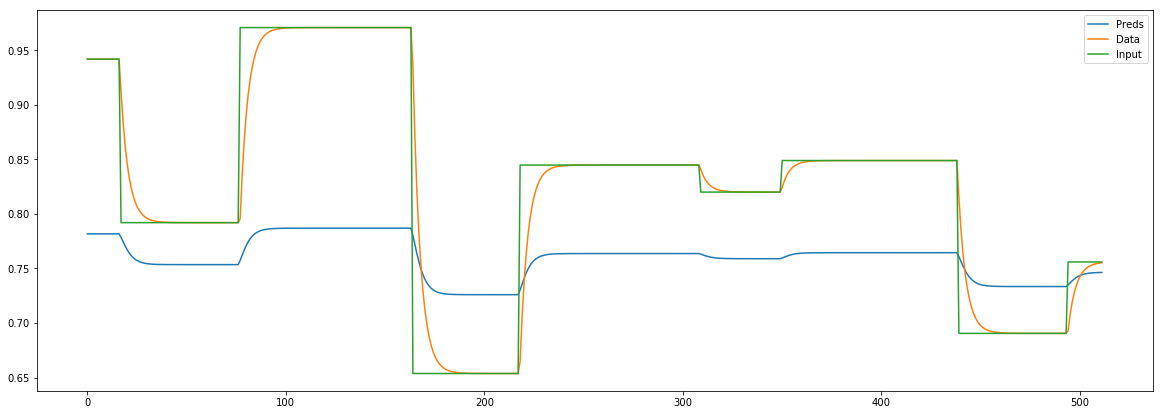

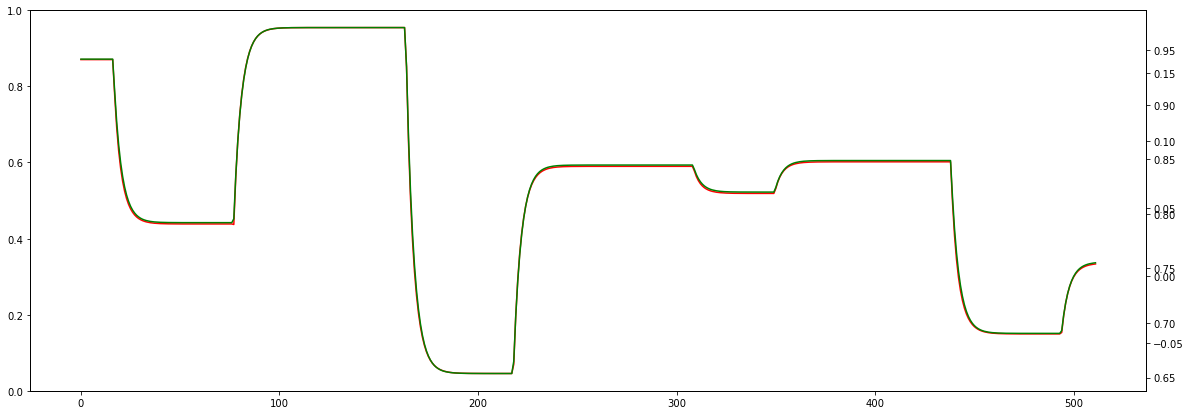

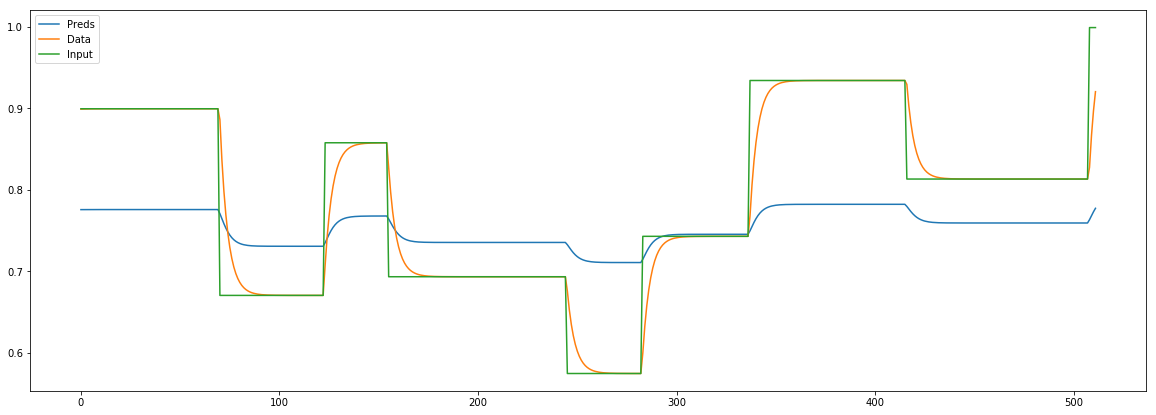

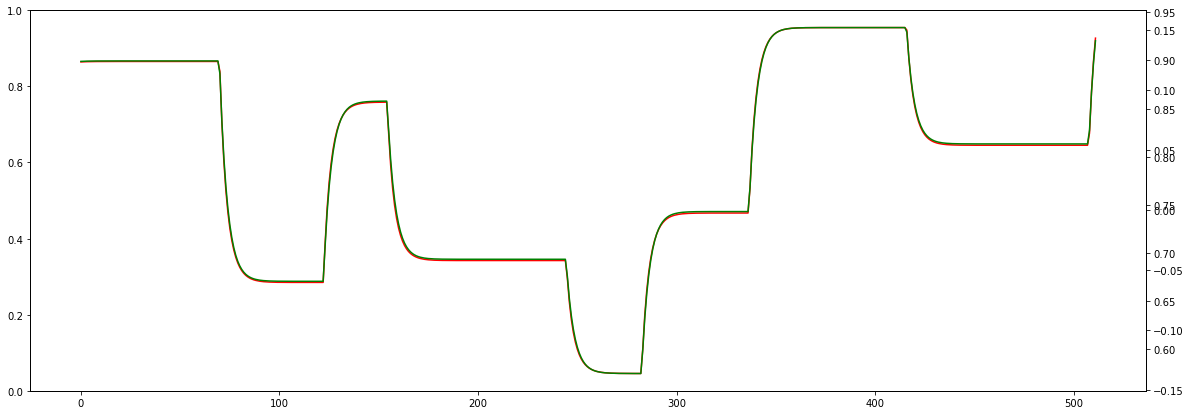

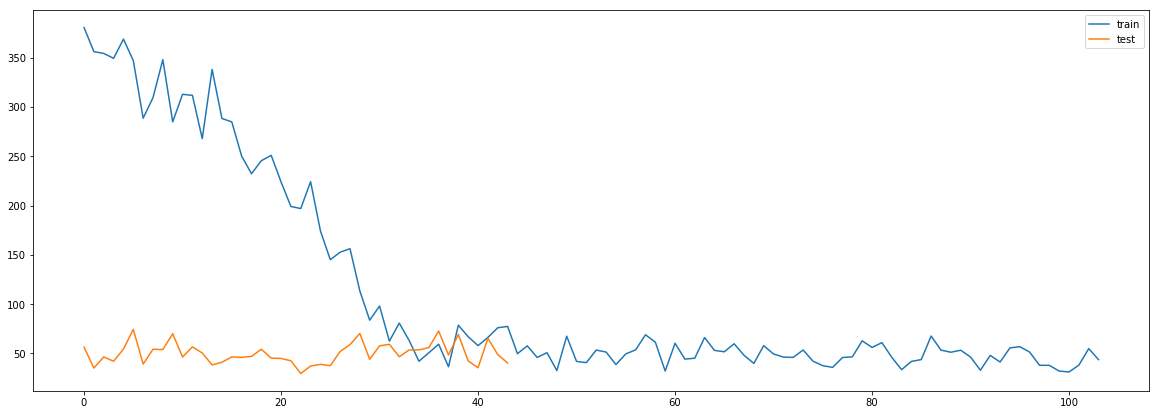

Epoch [0] train_loss[112.14722453630887] test_loss[50.0979077165777]


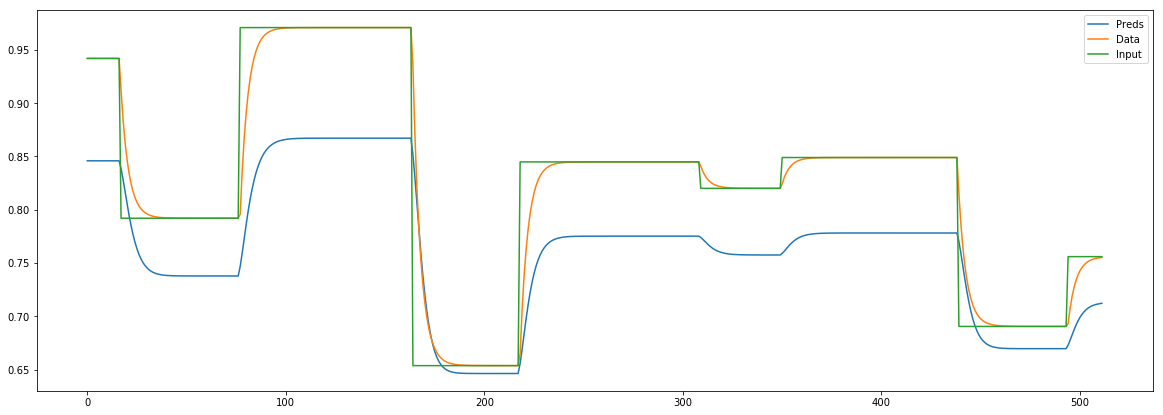

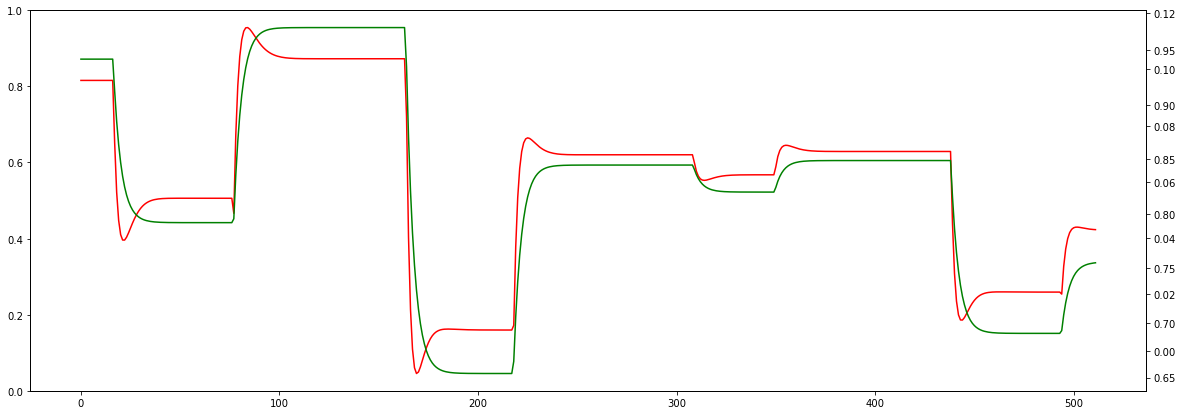

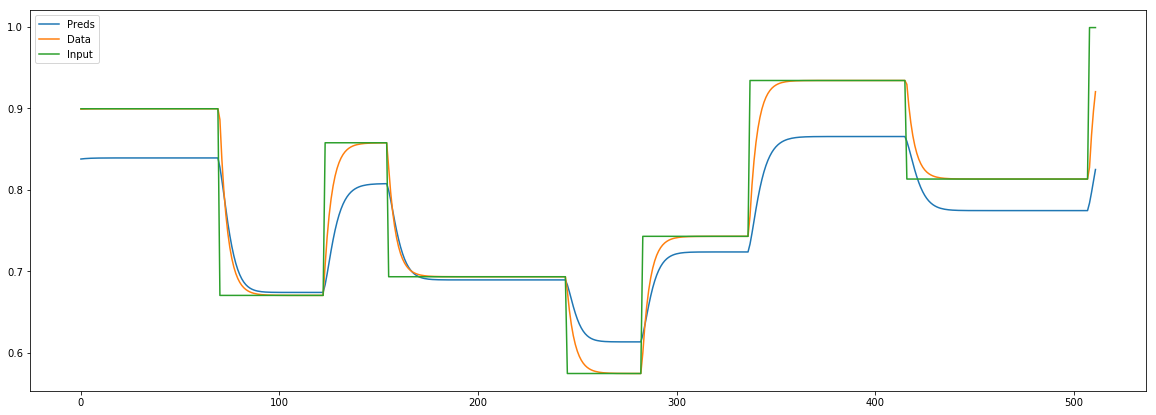

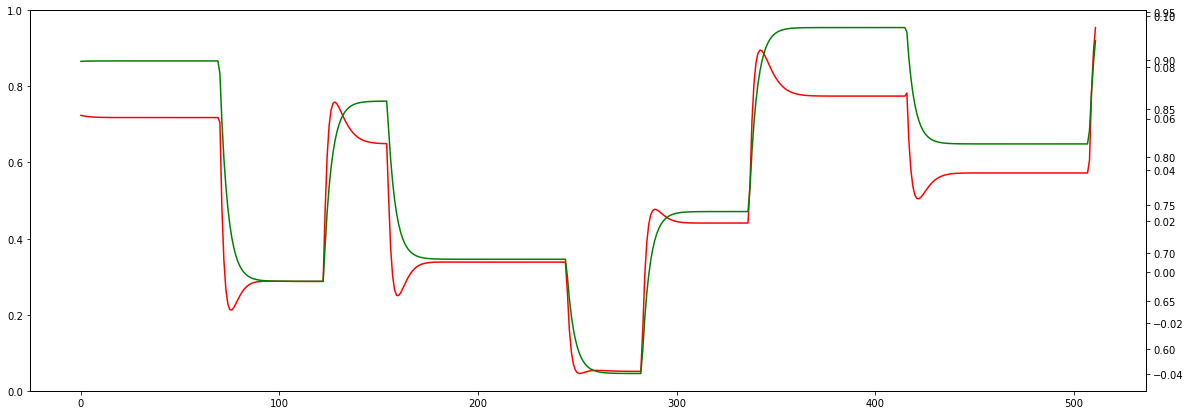

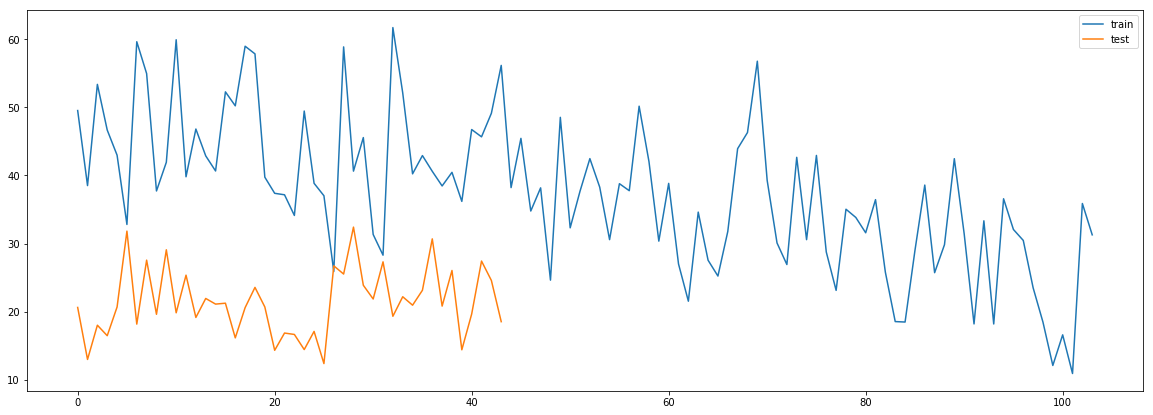

Epoch [1] train_loss[37.54617231625777] test_loss[21.42250544374639]


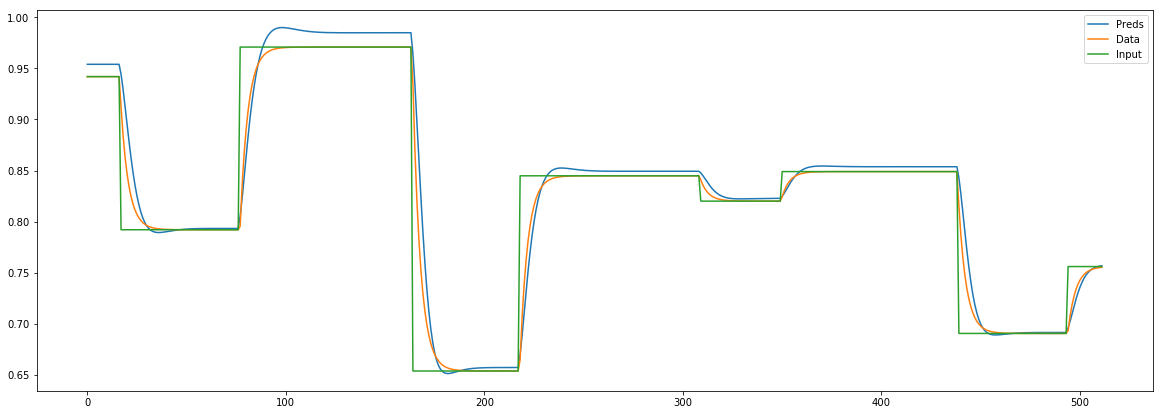

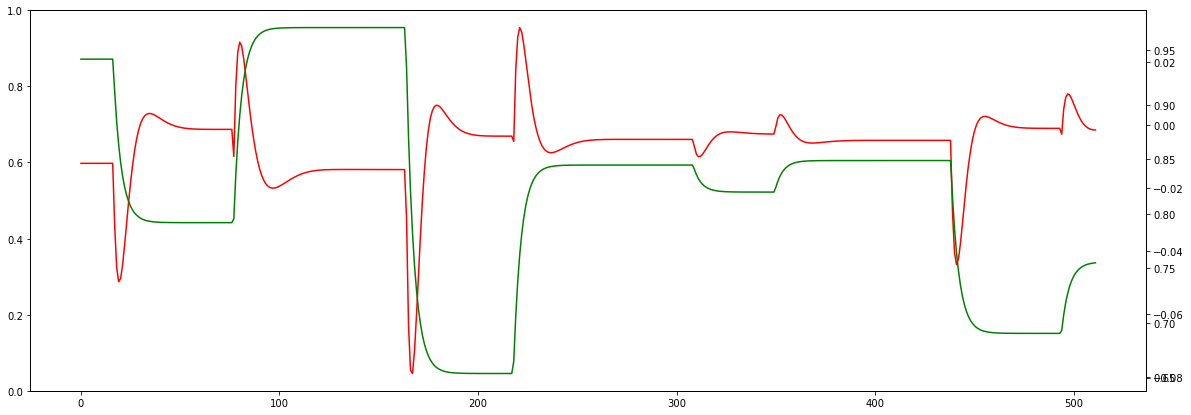

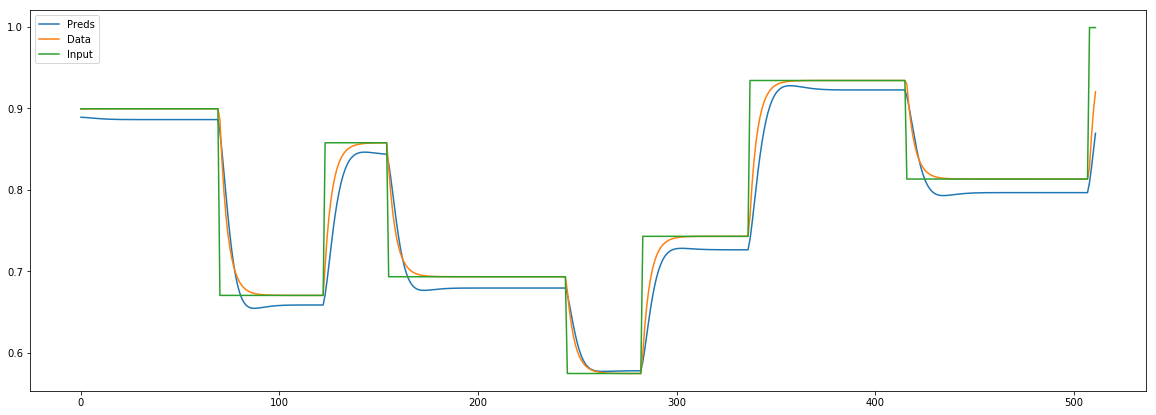

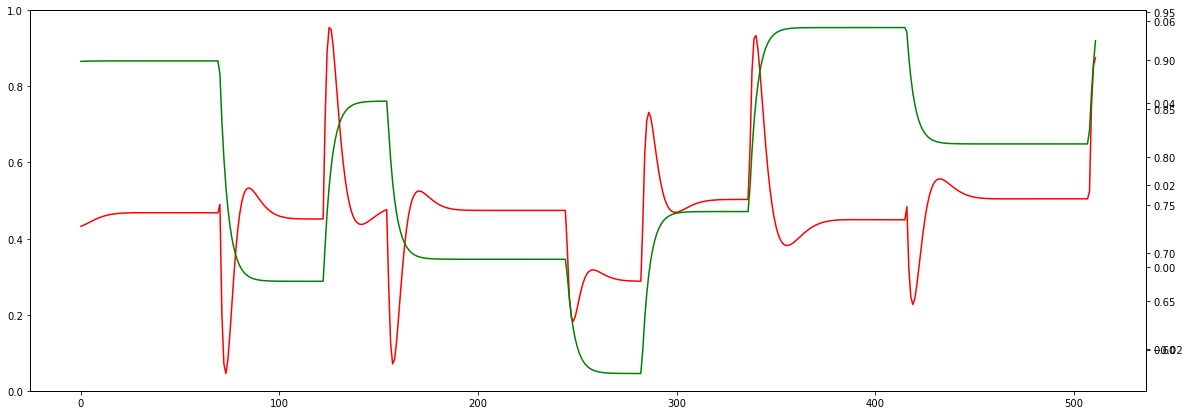

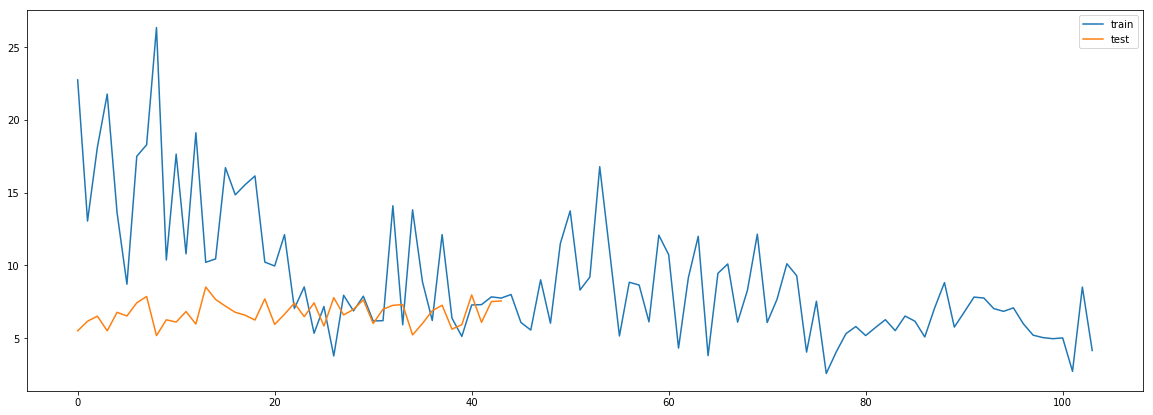

Epoch [2] train_loss[9.094487632696445] test_loss[6.718416344035756]


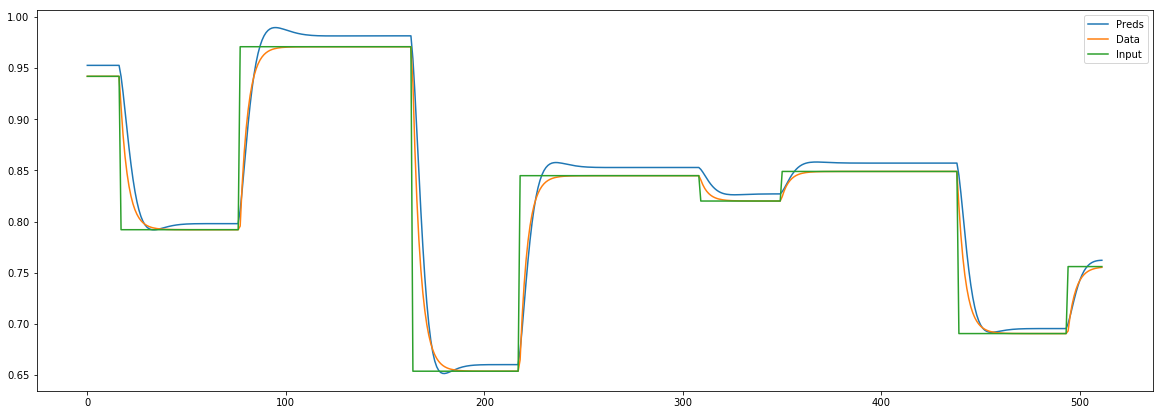

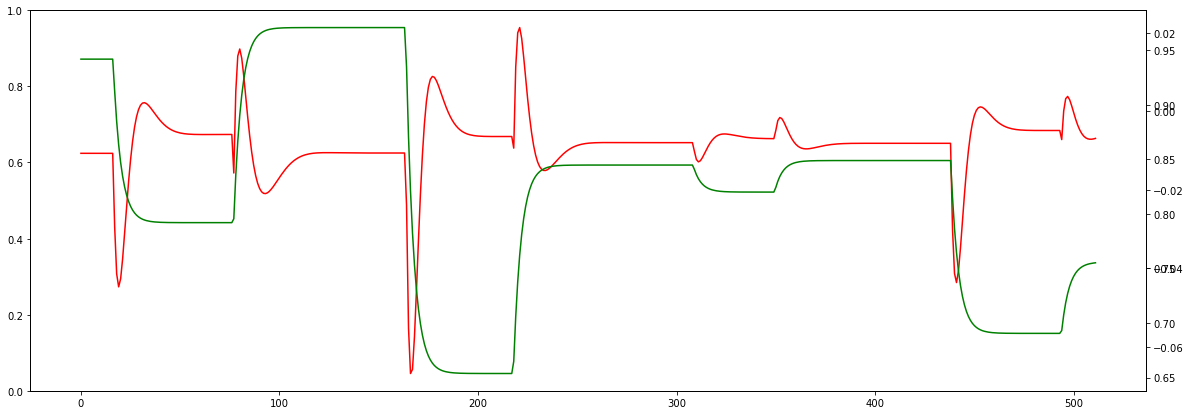

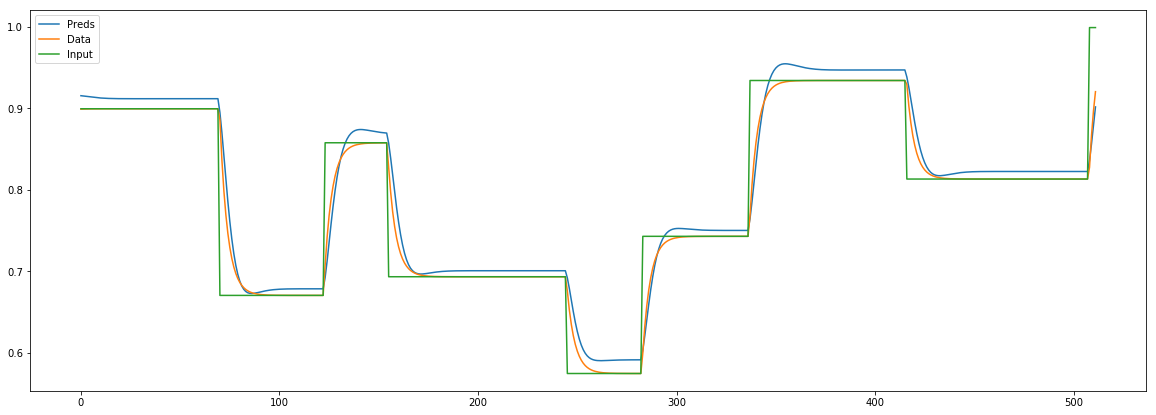

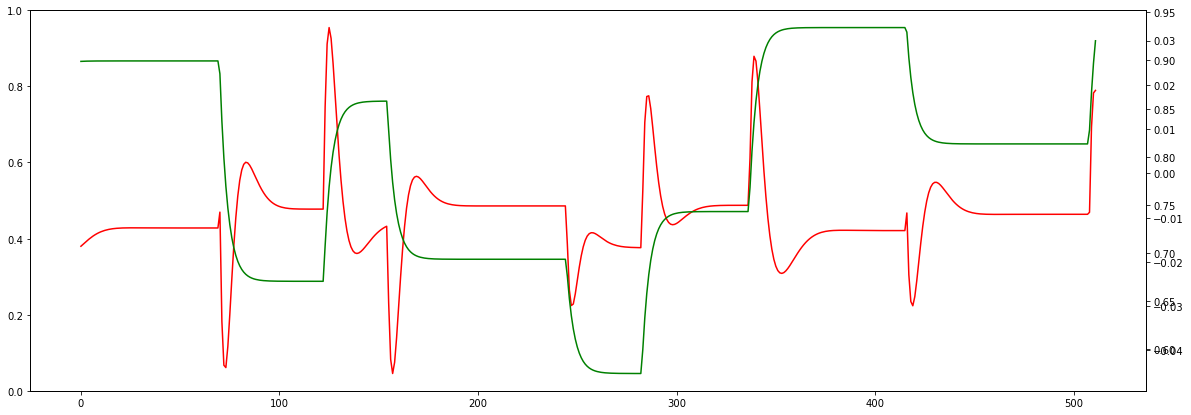

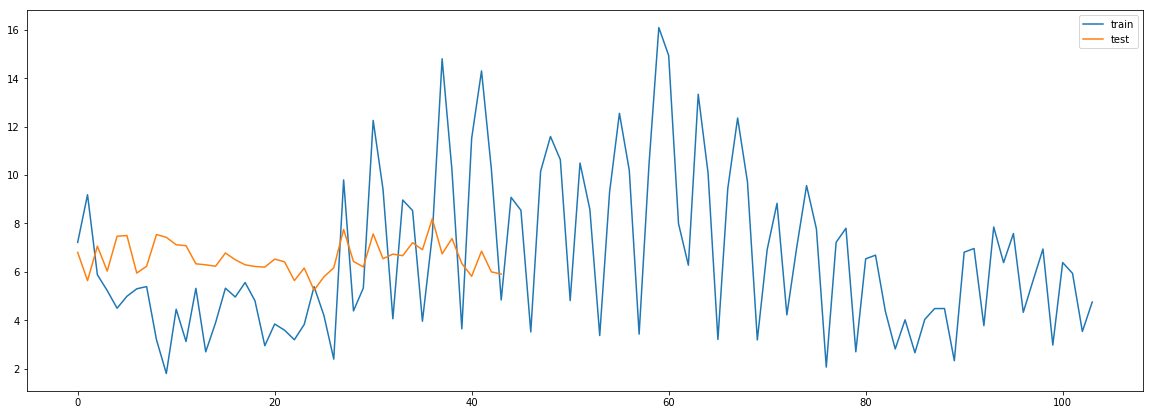

Epoch [3] train_loss[6.592601127349413] test_loss[6.588573011485013]


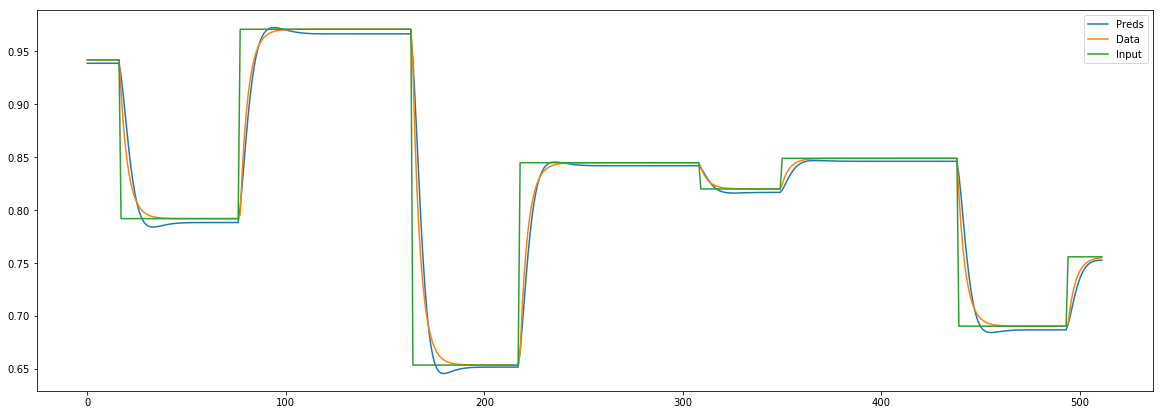

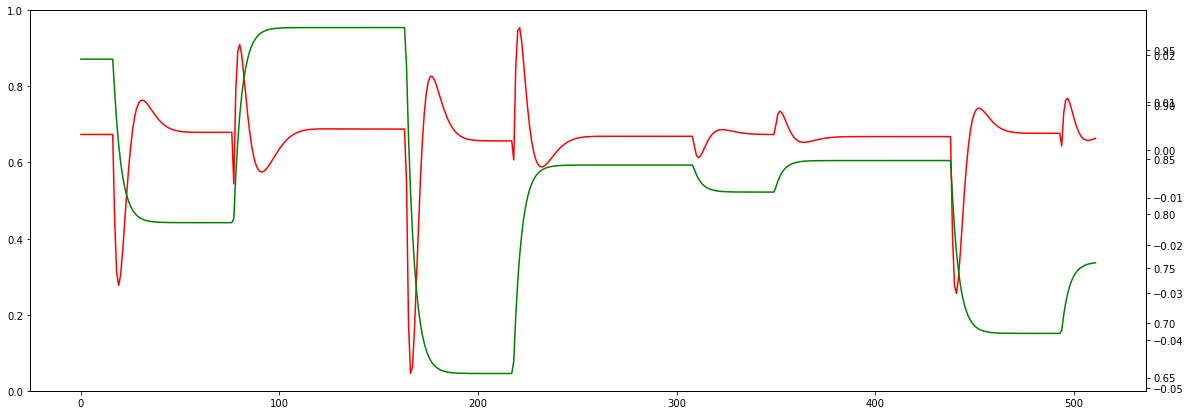

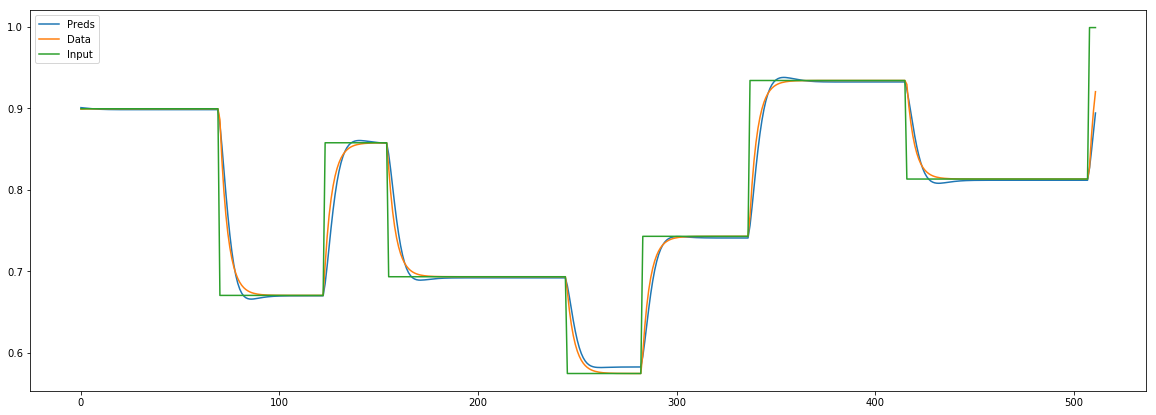

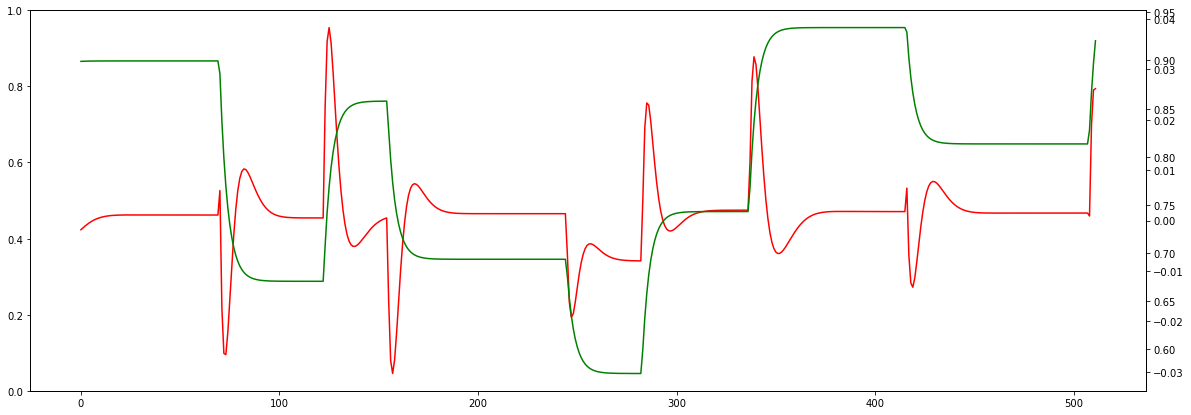

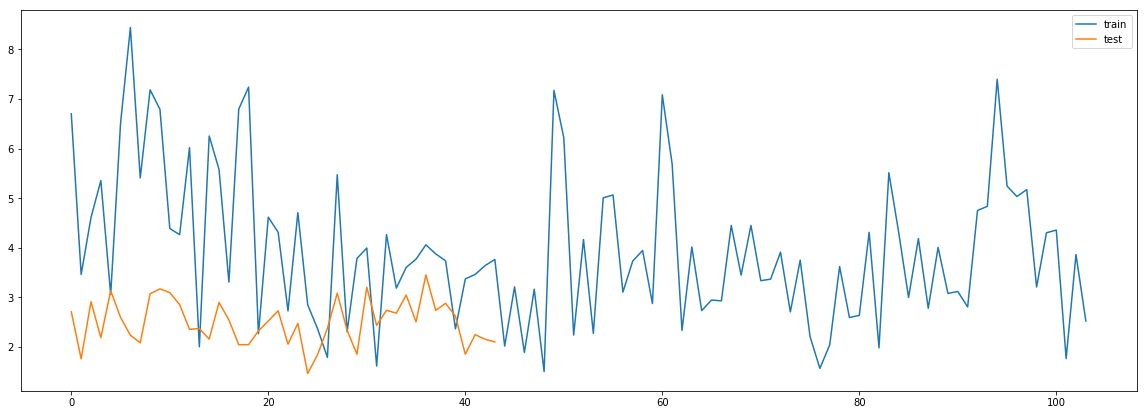

Epoch [4] train_loss[3.9452725454018664] test_loss[2.5005117600614373]


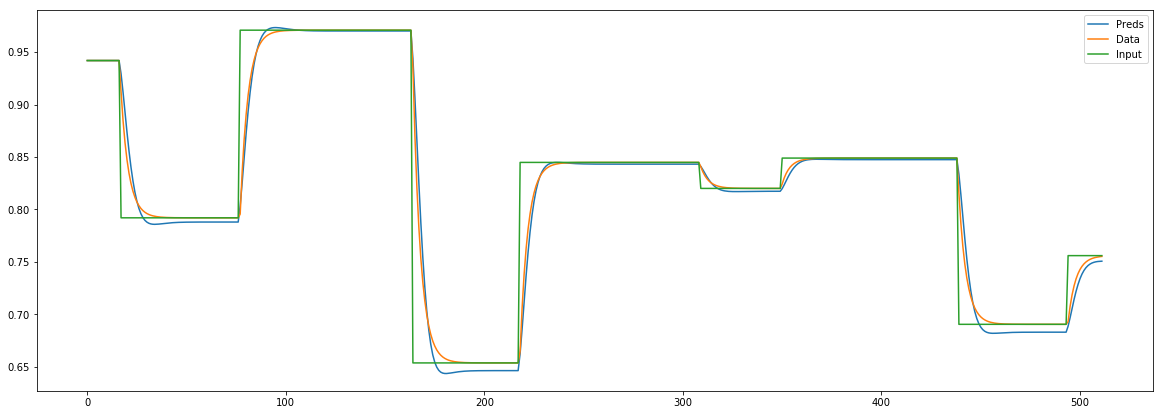

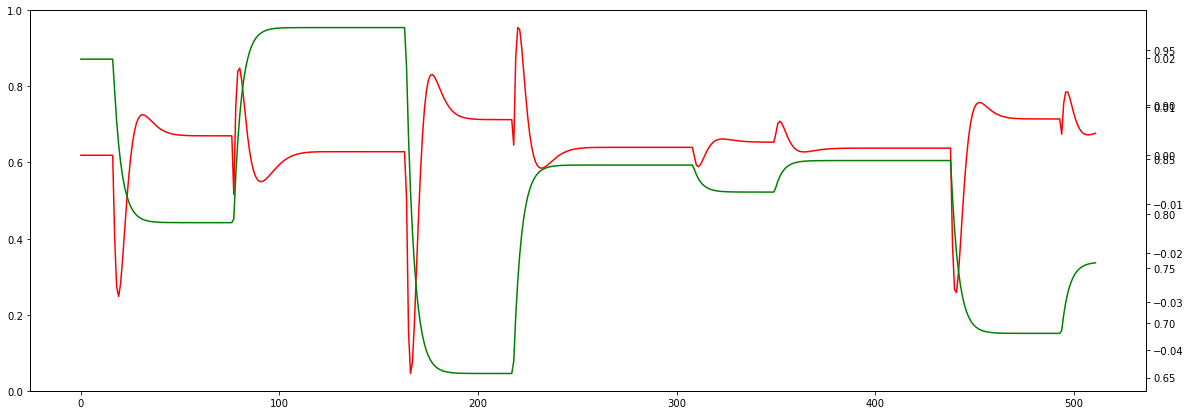

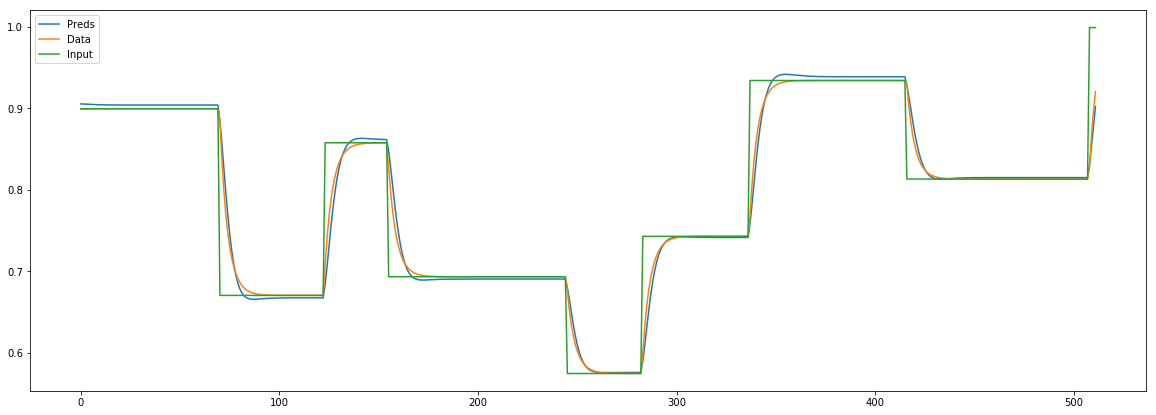

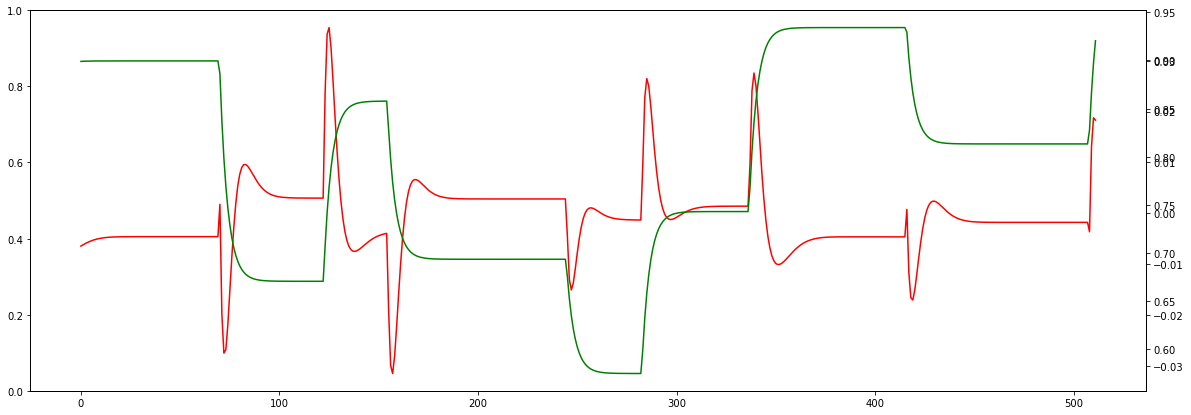

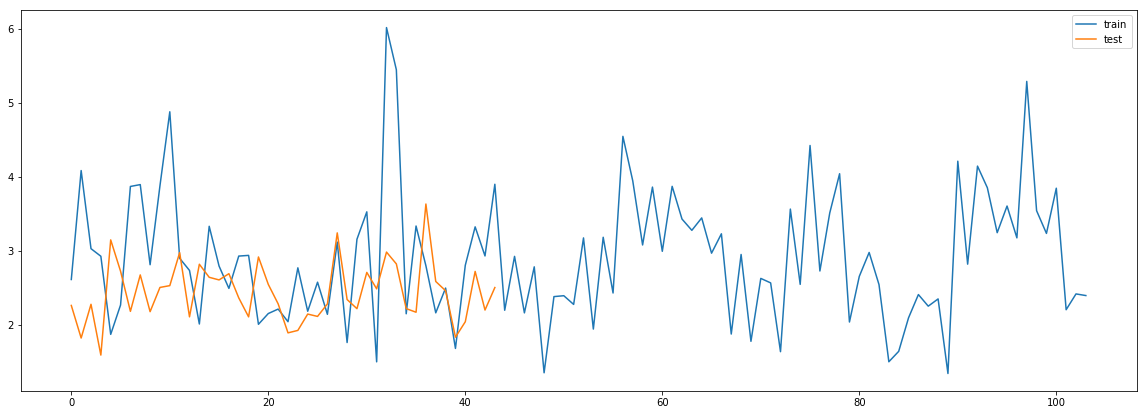

Epoch [5] train_loss[2.905208695393342] test_loss[2.4412273954261434]


KeyboardInterrupt: 

In [96]:
#####################
# Train model
#####################
num_epochs = 10
model.hidden = model.init_hidden()
hist = {"train_loss":np.zeros(num_epochs), 
        "test_loss":np.zeros(num_epochs),
       "train_local_loss":np.zeros(len(train_dl)),
       "test_local_loss":np.zeros(len(test_dl))}

for t in range(num_epochs):
    for i, data in enumerate(tqdm(train_dl)):
        x_batch, y_batch, indexes = data
        x_batch.transpose_(0, 1)
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
        #y_pred, train_loss = train_on_batch(model, x_batch, y_batch)
        y_pred = model(x_batch)
        loss = loss_fn(y_pred, y_batch)
        hist['train_local_loss'][i] = loss.item()

        # Zero out gradient, else they will accumulate between epochs
        optimiser.zero_grad()

        # Backward pass
        loss.backward()

        # Update parameters
        optimiser.step()
        
    plot_shared_scale(
        [(y_pred.detach().numpy(),"Preds" ),
         (y_batch.detach().numpy(), "Data"),
         (x_batch[-1].detach().numpy(), "Input")])
    residuals = y_batch-y_pred
    plot_multiscale([(residuals.detach().numpy(), "Red"),
                          (y_batch.detach().numpy(), "Green")]) 
    
    
    

        # validate during evaluation
    with torch.no_grad():
        model = model.eval()
        for i, data in enumerate(tqdm(test_dl)):
            x_batch_test, y_batch_test, indexes = data
            x_batch_test.transpose_(0, 1)
            y_pred_test = model(x_batch_test)
            loss = loss_fn(y_pred_test, y_batch_test)
            hist['test_local_loss'][i] = loss.item()
        model = model.train()
        
    plot_shared_scale([
            (y_pred_test.detach().numpy(),"Preds" ),
             (y_batch_test.detach().numpy(), "Data"),
             (x_batch_test[-1].detach().numpy(), "Input")])

    residuals = y_batch_test - y_pred_test
    plot_multiscale(
            [(residuals.detach().numpy(), "Red"), 
             (y_batch_test.detach().numpy(),"Green")])
    plot_shared_scale( [ (hist["train_local_loss"], "train"),
                        (hist["test_local_loss"], "test")])
    hist["train_loss"][t] = np.average(hist["train_local_loss"])
    hist["test_loss"][t] = np.average(hist["test_local_loss"])
    print(f"Epoch [{t}] train_loss[{hist['train_loss'][t]}] test_loss[{hist['test_loss'][t]}]")

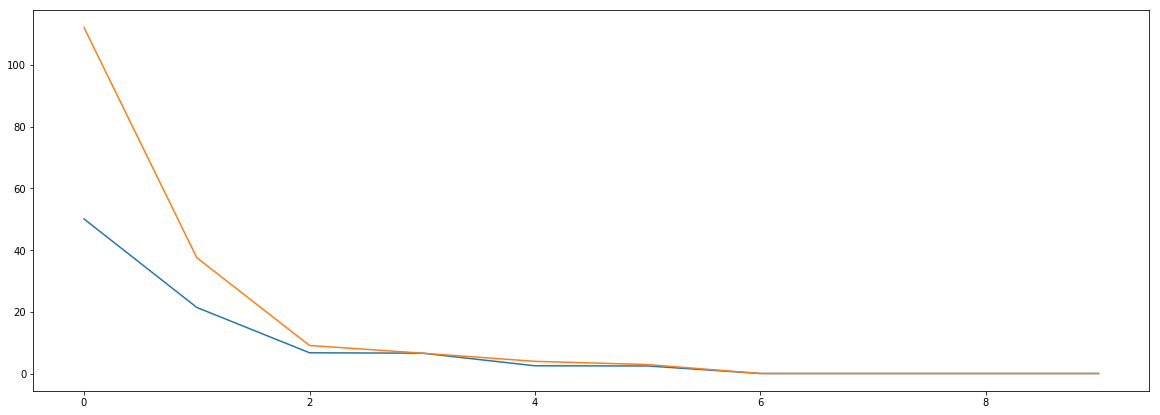

In [97]:
plt.plot(hist['test_loss'])
plt.plot(hist['train_loss'])

In [ ]:
model.buffers

In [ ]:
smoothed_train = []
smoothed_test = []
k_smooth = 50
for elm in range(hist['train_loss'][:-k_smooth].shape[0]):
    smoothed_train.append(np.average(hist['train_loss'][elm:elm+k_smooth]))
for elm in range(hist['test_loss'][:-k_smooth].shape[0]):
    smoothed_test.append(np.average(hist['test_loss'][elm:elm+k_smooth]))

In [ ]:
plt.plot(smoothed_train[10000:15000])
plt.plot(smoothed_test[10000:15000])

In [ ]:
plt.plot(hist['train_loss'][:], label="train")
plt.plot(hist['test_loss'][:], label="test")
plt.legend()

In [ ]:
while True:
    pass

In [ ]:
X_test[:, :test_size]

In [ ]:
plt.plot(hist['train_loss'][1000:], label="train")
plt.plot(hist['test_loss'][1000:], label="test")
plt.legend()

In [ ]:
plt.plot(hist['test_loss'])

In [ ]:
#

In [ ]:
while True:
    pass #piece of code preventing from overwriting previous results

In [ ]:
# TODO place it in the training loop for stopping

In [ ]:
# TODO provide config and experiment loggiing

In [ ]:
print("Epoch ", t, "MSE: ", loss.item())
plt.plot(y_pred_test[0:800].detach().numpy(), label="Preds")
plt.plot(y_test[0:800].detach().numpy(), label="Data")
plt.plot(X_test[input_size-1][0:800].detach().numpy(), label="Input")
plt.legend()
plt.show()
residuals = y_test-y_pred_test
plot_multiscale(data=[residuals.detach().numpy(), y_test.detach().numpy()], 
       colors = ["Red", "Green"])